<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [EMG](03.02-emg.ipynb) | [Contents](Index.ipynb) | [Joint reactions](03.04-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim")
conf = Conf(project_path=project_path)
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
def parse_conditions(d):
    return (
        d.assign(
            mass=lambda x: x["filename"]
            .str.contains("r08")
            .replace({True: 8, False: 12})
        )
        .merge(
            pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
                columns={"group": "men"}
            ),
            on="participant",
            how="left",
        )
        .assign(height=1)
    )

In [5]:
# suffix = "_StaticOptimization_activation"
suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(
                participant=ifile.parts[-3],
                filename=lambda x: ifile.stem + ifile.parts[-3] + f"{i}",
            )
            .reset_index()
            for i, ifile in enumerate(
                conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
            )
        ]
    )
    .pipe(parse_conditions)
    .assign(index=lambda x: x["index"] / 100)
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,hand_s2h_Fy,hand_s2h_Fz,hand_s2h_Tx,hand_s2h_Ty,hand_s2h_Tz,participant,filename,mass,men,height
0,0.00,5.867402,79.494889,12.756022,1.150912,5.177430,1.462156,0.771106,0.546189,3.902457,...,0.503288,1.328618,-0.009884,-0.010004,0.008113,antc,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,8,0,1
1,0.01,1.489000,82.246585,36.837055,1.184633,5.261847,1.466356,0.771499,0.540825,3.910167,...,0.073452,1.734759,-0.002444,-0.033049,-0.001865,antc,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,8,0,1
2,0.02,1.453019,77.829019,43.778693,1.239085,5.415727,1.486409,0.772883,0.521287,4.047193,...,-1.166118,6.387258,-0.084561,-0.104206,0.005356,antc,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,8,0,1
3,0.03,1.471788,60.668184,62.076805,1.278610,5.517520,1.505426,0.772386,0.505812,10.365730,...,-0.853038,14.559491,-0.559183,-0.153394,-0.166301,antc,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,8,0,1
4,0.04,9.994662,47.191065,75.186652,1.279492,5.523854,1.506283,0.768554,0.499237,20.290365,...,7.053458,21.812958,-1.470454,-0.819556,-0.165831,antc,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,8,0,1


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [6]:
act.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8       85
     12      84
1    8       53
     12      41
dtype: int64

In [7]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].to_list()

In [8]:
act = act.query("filename == @balanced_trials")
act.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8       41
     12      41
1    8       41
     12      41
dtype: int64

### Drop unwanted variables

In [9]:
id_vars = ["filename", "participant", "men", "height", "mass", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,index,variable,value
0,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,antc,0,1,8,0.00,LVS,5.867402
1,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,antc,0,1,8,0.01,LVS,1.489000
2,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,antc,0,1,8,0.02,LVS,1.453019
3,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,antc,0,1,8,0.03,LVS,1.471788
4,wu_expertsnovicesG_1_r08_3_StaticOptimization_...,antc,0,1,8,0.04,LVS,9.994662


In [10]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_s2h_Fx",
    "hand_s2h_Fy",
    "hand_s2h_Fz",
    "hand_s2h_Tx",
    "hand_s2h_Ty",
    "hand_s2h_Tz",
    "hand_s2h_px",
    "hand_s2h_py",
    "hand_s2h_pz",
]

act_melt = act_melt.query("variable != @blacklist")

In [11]:
# gh_muscles = [
#     "DELT1",
#     "DELT2",
#     "DELT3",
#     "INFSP",
#     "LAT",
#     "PECM1",
#     "PECM2",
#     "PECM3",
#     "SUBSC",
#     "SUPSP",
#     "TMAJ",
#     "TMIN",
#     "CORB",
# ]
# act_melt = act_melt.query("variable == @gh_muscles")

## Description

In [12]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 93.22%


In [13]:
x = act_melt.groupby(["variable", "index"])["value"].mean().reset_index()
x.head()

,variable,index,value
0,CORB,0.00,9.061630
1,CORB,0.01,7.505108
2,CORB,0.02,8.560398
3,CORB,0.03,9.789993
4,CORB,0.04,11.591097


In [14]:
act_melt.groupby(["variable", "index"])["value"].mean().reset_index().groupby(
    "variable"
)["value"].apply(lambda x: (x < 50).sum()).sort_values()

variable
DELT2          0
INFSP          0
TRP1           0
SUBSC          2
PECM1          2
bic_b          3
bic_l          6
tric_long     14
DELT1         19
PECM2         19
SUPSP         47
SRA1          50
TMIN          84
TRP2         101
TRP4         101
TMAJ         101
TRP3         101
CORB         101
SRA2         101
RMN          101
RMJ2         101
RMJ1         101
PMN          101
PECM3        101
LVS          101
LAT          101
DELT3        101
SRA3         101
SBCL         101
Name: value, dtype: int64

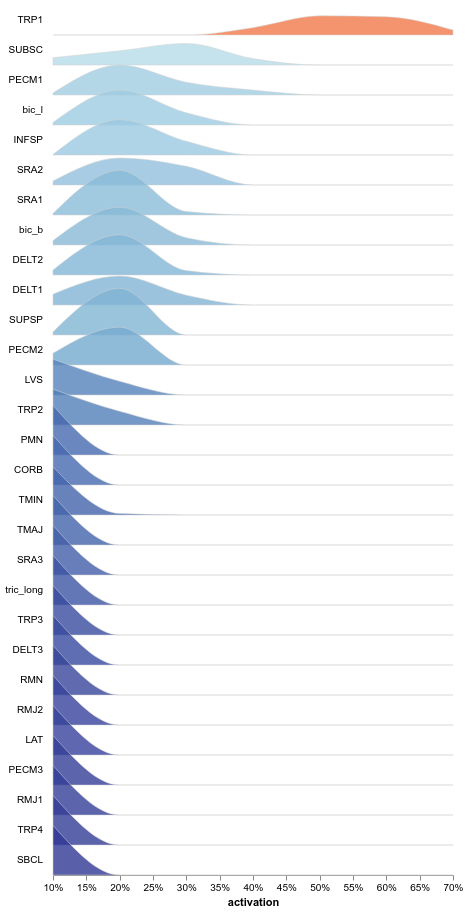

In [14]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [15]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,index,value
0,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,beng,0,1,8,0.00,537.652252
1,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,beng,0,1,8,0.01,503.009532
2,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,beng,0,1,8,0.02,510.740470
3,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,beng,0,1,8,0.03,580.696279
4,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,beng,0,1,8,0.04,634.272977


In [16]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value  \
index                                                                                  0.00   
filename                                           participant men height mass                
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8      537.652252   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     1004.834451   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8      634.650608   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8      524.322496   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8      901.631958   

                                                                                            \
index                                                                                 0.01   
filename                                           participant men height mass               
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     503.009532   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     980.281189   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     417.347401   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     698.306533   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     769.920297   

                                                                                             \
index                                                                                  0.02   
filename                                           participant men height mass                
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8      510.740470   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     1028.988992   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8      281.121465   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     1046.816065   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8      655.698137   

                                                                                             \
index                                                                                  0.03   
filename                                           participant men height mass                
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8      580.696279   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     1151.002461   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8      289.796524   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     1336.815463   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8      556.517525   

                                                                                             \
index                                                                                  0.04   
filename                                           participant men height mass                
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8      634.272977   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     1218.930878   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8      542.375737   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     1464.664931   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8      589.362738   

                                                                                             \
index                                                                                  0.05   
filename                                           participant men height mass                
wu_e

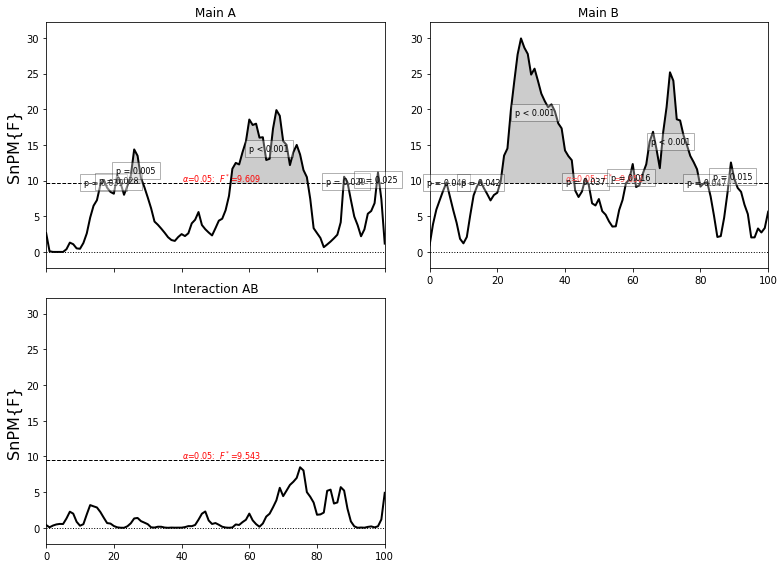

In [17]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [18]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)

In [19]:
effect = {"main sex": "men", "main mass": "mass"}
clusters = describe_clusters(
    clusters, sum_act.query("participant != @blacklist"), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
3,main sex,0.0,0.54,0.77,0 - 1,-353.86,-0.58,medium
8,main mass,0.0,0.21,0.42,8 - 12,-476.46,-0.71,medium
11,main mass,0.0,0.62,0.79,8 - 12,-357.62,-0.59,medium


In [20]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [21]:
base = alt.Chart(sum_act.query("participant != @blacklist")).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

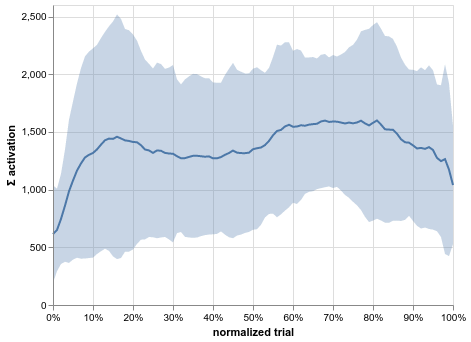

In [22]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [24]:
from scipy.signal import find_peaks

t = sum_act.groupby("index")["value"].agg(["mean", "std"])
p, _ = find_peaks(t["mean"], distance=50)
# t.iloc[p, :].multiply(100).round()
t.iloc[p, :].round()

,mean,std
index,,
0.16,1458.0,1060.0
0.81,1599.0,852.0


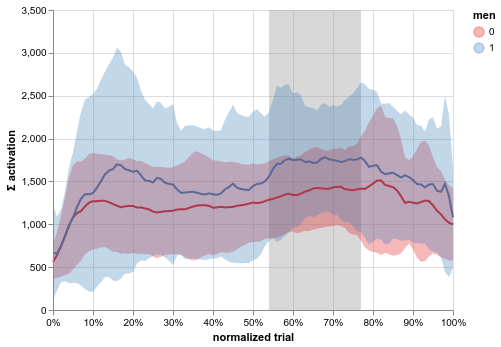

In [25]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

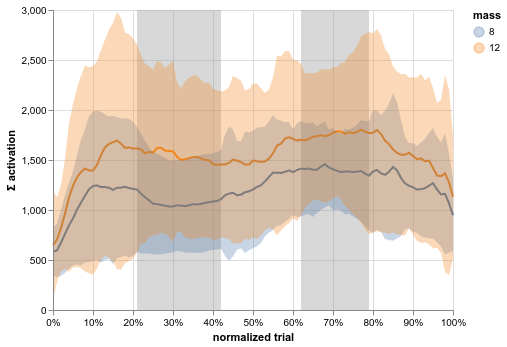

In [26]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

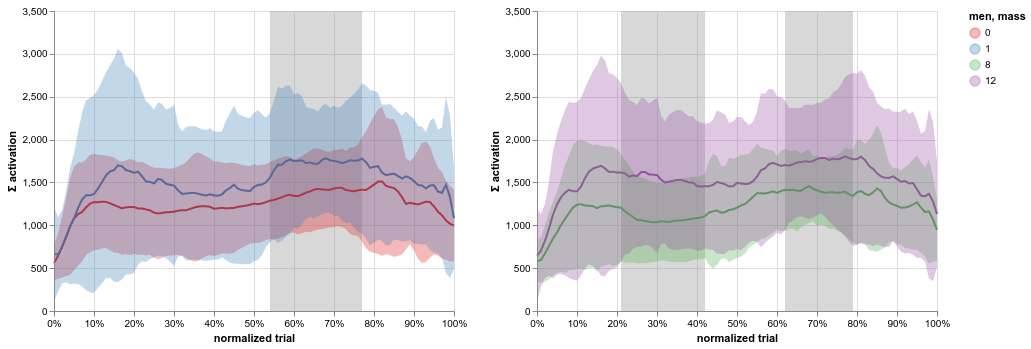

In [27]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

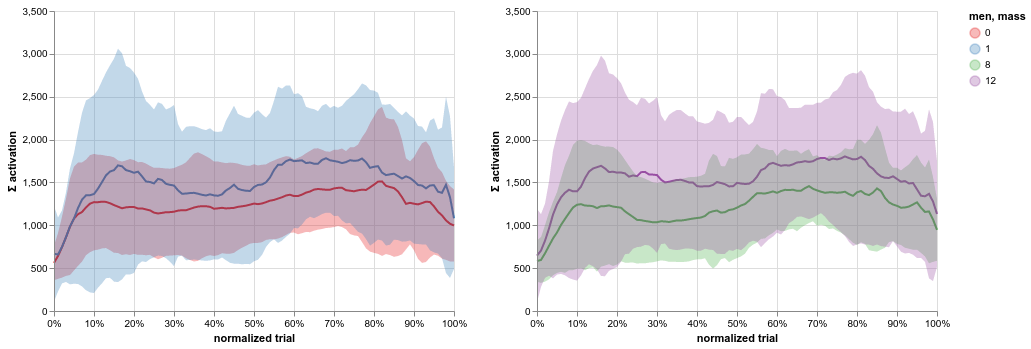

In [28]:
(
    (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

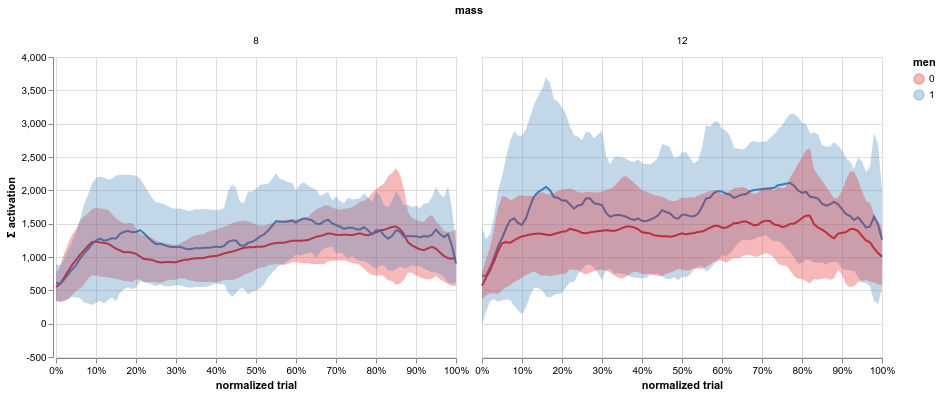

In [29]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## ECDF

### ECDF on activations

In [30]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [31]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value  \
ecdf                                                                            0.000341   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.406690   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     0.522861   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     0.455510   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     0.524651   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     0.462222   

                                                                                          \
ecdf                                                                            0.010242   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.425558   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     0.594408   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     0.489990   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     0.590893   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     0.487741   

                                                                                          \
ecdf                                                                            0.020143   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.433498   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     0.621892   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     0.516996   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     0.635972   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     0.500841   

                                                                                          \
ecdf                                                                            0.030044   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.441445   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     0.658446   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     0.548669   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     0.663088   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     0.723469   

                                                                                          \
ecdf                                                                            0.039945   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.685028   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 2           1   1      8     0.880307   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 8           1   1      8     0.734128   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 9           0   1      8     1.165635   
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 11          0   1      8     0.810730   

                                                                                          \
ecdf                                                                            0.049846   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_f... 1           0   1      8     0.710230   
wu_expertsnovicesD_1_r08_1_Sta

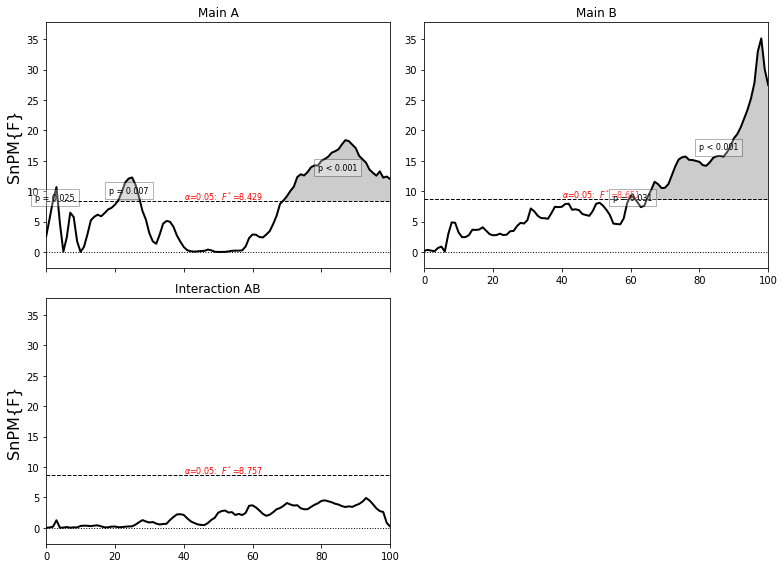

In [32]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [33]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.025,0.0196867,0.0334303
1,main sex,0.00733333,0.206851,0.269919
2,main sex,0,0.682363,0.990099
3,main mass,0.031,0.589199,0.608107
4,main mass,0,0.640768,0.990099


In [34]:
effect = {"main sex": "men", "main mass": "mass"}
clusters = describe_clusters(
    clusters, y.stack().reset_index().rename(columns={"ecdf": "index"}), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
1,main sex,0.007333,0.21,0.27,0 - 1,0.21,0.48,small
2,main sex,0.000000,0.68,0.99,0 - 1,-24.80,-0.24,small
4,main mass,0.000000,0.64,0.99,8 - 12,-27.24,-0.26,small


In [35]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [36]:
ecdf = y.stack().reset_index()
base = alt.Chart(ecdf).encode(alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf"))
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

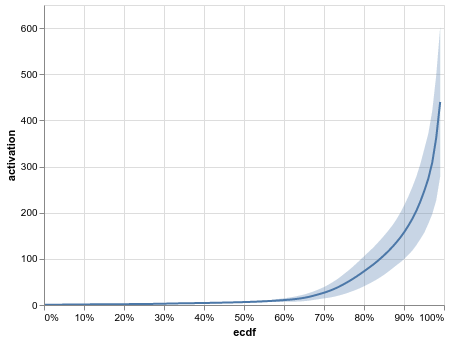

In [37]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [40]:
print(ecdf.query("ecdf < 0.5")["value"].agg(["mean", "std"]))
print(ecdf.query("ecdf > 0.5")["value"].agg(["mean", "std"]))

mean    2.692065
std     1.717897
Name: value, dtype: float64
mean     87.132058
std     112.060083
Name: value, dtype: float64


In [41]:
value = [0.6, 0.8, 1]
# index = (df['values'] - value).abs().idxmin()
x = ecdf.groupby("ecdf")["value"].agg(["mean", "std"]).reset_index()

[x.iloc[x["ecdf"].sub(i).abs().idxmin()].round() for i in value]

[ecdf     1.0
 mean    11.0
 std      4.0
 Name: 61, dtype: float64, ecdf     1.0
 mean    74.0
 std     33.0
 Name: 81, dtype: float64, ecdf      1.0
 mean    440.0
 std     162.0
 Name: 100, dtype: float64]

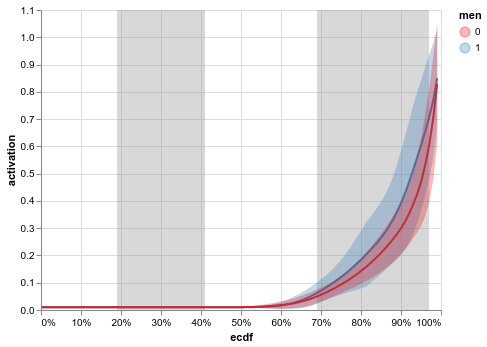

In [36]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

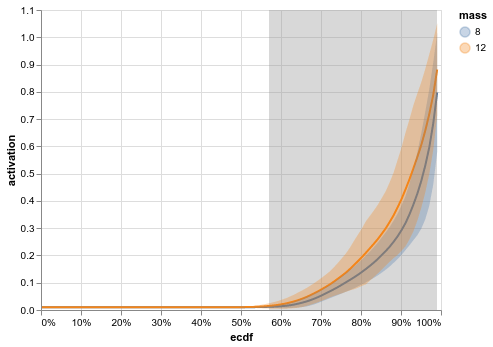

In [37]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

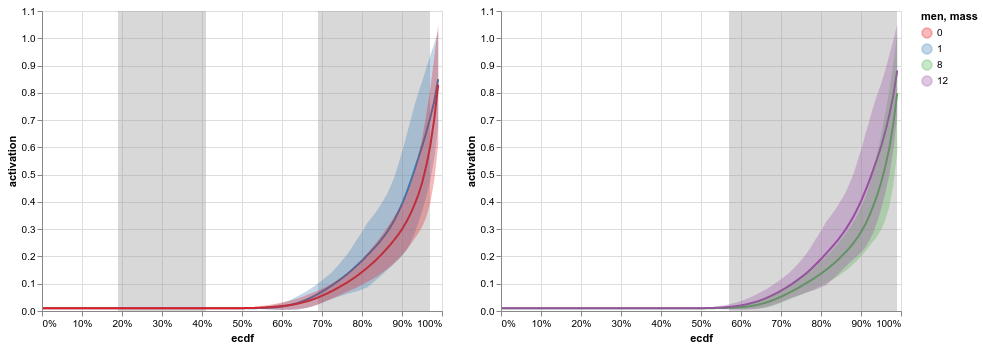

In [38]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

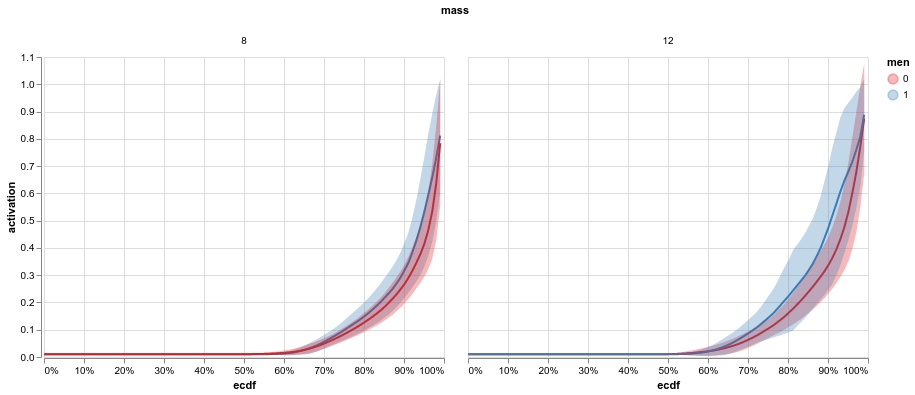

In [39]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## $\sum\sum\text{activations}$

In [40]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,value
0,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,blam,1,1,8,376.223976
1,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,160.992748
2,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,fras,1,1,8,256.942222
3,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,jead,1,1,8,234.608680
4,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,jeam,1,1,8,241.684213


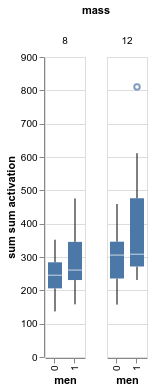

In [41]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

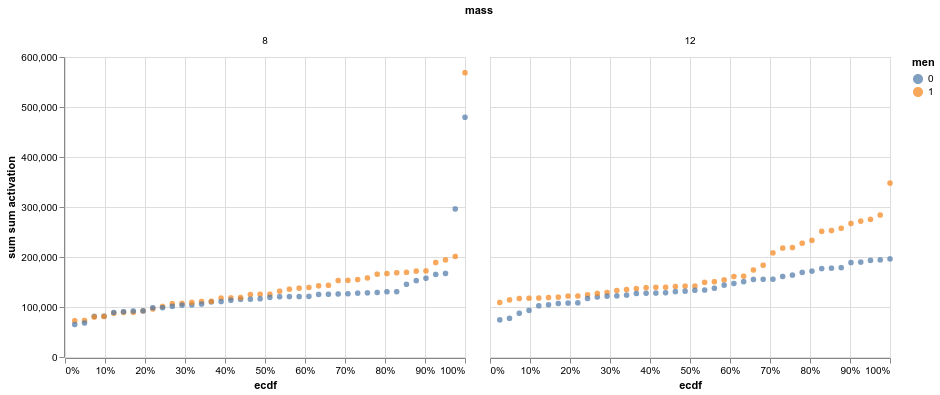

In [39]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [EMG](03.02-emg.ipynb) | [Contents](Index.ipynb) | [Joint reactions](03.04-joint-reactions.ipynb) >